In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import self_attention_cv
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

import torch
device = torch.device('cpu')


#JAX
import jax
import jax.numpy as jnp

from jax_cosmo.scipy import interpolate as jax_interpolate

# Probably should specify in the outer script, not the inner modules
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)

# for Matern kernel with Modified Bessel of the 2nd kind (tfp>=0.17.0-dev20220322)
import tensorflow_probability as tfp


#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)

fig = plt.figure()
#plt.plot()
mpl.style.use('default')
rcParams = {
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "lightgray",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black",
    "legend.facecolor":'lightgray',
    "legend.edgecolor":'black',
    'axes.titlecolor': 'white'}

def set_style():
    global fig
    mpl.style.use('default')
    plt.rcParams.update(rcParams)
    fig.patch.set_alpha(0)

FS = 18 # fontsize


import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

def to_date(time_array,offset_date='2000-01-01T00:00:00'):
    return np.array([pd.Timedelta(x,'days').round('d')+pd.Timestamp(offset_date) for x in time_array])

/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


<Figure size 432x288 with 0 Axes>

In [2]:
from functools import partial

class Convolved_Matern_Walk():


    def __init__(self,softening=1e-10,diagonal_softening=1e-8):

        self.softening = softening
        self.diagonal_softening = diagonal_softening

    def Sotened_powerlaw(self,freq,Correlation_time,order_nu):

        return jnp.power(1+(2*np.pi*freq*Correlation_time)**2,-order_nu-0.5)


    def Double_DRW_spectrum(self,frequencies,Correlation_time,Reverberation_time,Variance=1,grid_step = 1):

        accretion_spectrum = self.Sotened_powerlaw(frequencies,Correlation_time,order_nu=0.5)
        #accretion_spectrum = self.Matern_spectrum(frequencies,Correlation_time,order_nu)
        transfer_spectrum = self.Sotened_powerlaw(frequencies,Reverberation_time,order_nu=0.5)

        flux_spectrum = accretion_spectrum*transfer_spectrum

        Normalisation = Variance * (Correlation_time + Reverberation_time) /grid_step

        return Normalisation*flux_spectrum

    def RDRW_covariance(self,abs_time_difference, Correlation_time, Reverberation_time, Variance = 1.):

        Tau_ratio =  abs_time_difference / Correlation_time
        Rho_ratio = abs_time_difference / (Reverberation_time + self.softening)

        # caps of exponential factors to facilitate Cholesky decomposition
        #Tau_dependence = (Tau_ratio< -np.log(self.softening)) * jnp.exp(-Tau_ratio)
        #Rho_dependence = (Rho_ratio< -np.log(self.softening)) * jnp.exp(-Rho_ratio)

        Tau_dependence = jnp.exp(-Tau_ratio)
        Rho_dependence = jnp.exp(-Rho_ratio)

        Normalisation = 1. / (Correlation_time  - Reverberation_time)

        Time_dependence = Correlation_time * Tau_dependence - Reverberation_time * Rho_dependence

        return Variance*Normalisation * Time_dependence


    def conditional_distribution(self,desired_times,time_array, values_array,
            Correlation_time, Reverberation_time, Variance = 1., Mean = 0.):

        time_difference = desired_times[None,:] - time_array[:,None]

        Mutual_Correlations = self.RDRW_covariance(jnp.abs(time_difference),Correlation_time,Reverberation_time)

        Reference_Corr_matrix = self.RDRW_covariance(jnp.abs(time_array[None,:] - time_array[:,None]),Correlation_time,Reverberation_time)   + np.eye(len(time_array)) * self.diagonal_softening

        Reference_Cholesky = jax.scipy.linalg.cholesky(Reference_Corr_matrix, lower=True, overwrite_a=True)

        # Mean prediction
        alpha = jax.scipy.linalg.cho_solve((Reference_Cholesky, True), values_array)

        conditional_Mean = Mean + Mutual_Correlations.T @ alpha
        # f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)

        Mutual_Corr_matrix = jax.scipy.linalg.solve_triangular(Reference_Cholesky,Mutual_Correlations,lower=True,check_finite=False)

        desired_time_difference = desired_times[None,:] - desired_times[:,None]
        self_Correlation_matrix = self.RDRW_covariance(jnp.abs(desired_time_difference),Correlation_time,Reverberation_time)

        conditional_Covariance_matrix = Variance * (self_Correlation_matrix -  Mutual_Corr_matrix.T @ Mutual_Corr_matrix)

        return conditional_Mean,conditional_Covariance_matrix
Quasar = Convolved_Matern_Walk()

In [3]:
from functools import partial
from scipy.interpolate import BSpline

@jax.jit
def split_six_keys(key):
  return jax.random.split(key,6)

class RDRW():

    def __init__(self,softening=1e-10,diagonal_softening=1e-8):

        self.softening = softening
        self.diagonal_softening = diagonal_softening


    def Power_spectrum(self,frequencies,Correlation_time,Reverberation_time,Variance = 1.,grid_step=1.):

        Normalisation = Variance**2 * (Correlation_time + Reverberation_time) /grid_step

        omega = 2* np.pi* frequencies

        Tau_factor = (1+omega**2 * Correlation_time**2)
        Rho_factor = (1+omega**2 * Reverberation_time**2)

        return Normalisation/Tau_factor/Rho_factor + self.diagonal_softening


    def RDRW_covariance(self,abs_time_difference, Correlation_time, Reverberation_time, Variance = 1.):

        Tau_ratio =  abs_time_difference / Correlation_time
        Rho_ratio = abs_time_difference / (Reverberation_time + self.softening)

        # caps of exponential factors to facilitate Cholesky decomposition
        #Tau_dependence = (Tau_ratio< -np.log(self.softening)) * jnp.exp(-Tau_ratio)
        #Rho_dependence = (Rho_ratio< -np.log(self.softening)) * jnp.exp(-Rho_ratio)

        Tau_dependence = jnp.exp(-Tau_ratio)
        Rho_dependence = jnp.exp(-Rho_ratio)

        Normalisation = 1. / (Correlation_time  - Reverberation_time)

        Time_dependence = Correlation_time * Tau_dependence - Reverberation_time * Rho_dependence

        return Variance*Normalisation * Time_dependence


    def conditional_distribution(self,desired_times,time_array, values_array,
            Correlation_time, Reverberation_time, Variance = 1., Mean = 0.):

        time_difference = desired_times[None,:] - time_array[:,None]

        Mutual_Correlations = self.RDRW_covariance(jnp.abs(time_difference),Correlation_time,Reverberation_time)

        Reference_Corr_matrix = self.RDRW_covariance(jnp.abs(time_array[None,:] - time_array[:,None]),Correlation_time,Reverberation_time)   + np.eye(len(time_array)) * self.diagonal_softening

        Reference_Cholesky = jax.scipy.linalg.cholesky(Reference_Corr_matrix, lower=True, overwrite_a=True)

        # Mean prediction
        alpha = jax.scipy.linalg.cho_solve((Reference_Cholesky, True), values_array)

        conditional_Mean = Mean + Mutual_Correlations.T @ alpha
        # f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)

        Mutual_Corr_matrix = jax.scipy.linalg.solve_triangular(Reference_Cholesky,Mutual_Correlations,lower=True,check_finite=False)

        desired_time_difference = desired_times[None,:] - desired_times[:,None]
        self_Correlation_matrix = self.RDRW_covariance(jnp.abs(desired_time_difference),Correlation_time,Reverberation_time)

        conditional_Covariance_matrix = Variance * (self_Correlation_matrix -  Mutual_Corr_matrix.T @ Mutual_Corr_matrix)

        return conditional_Mean,conditional_Covariance_matrix

class RDRW_simulator(RDRW):

    def __init__(self,duration = 10, Saturation_time=10, grid_step = 4, random_seed = 7, softening=1e-10,diagonal_softening=1e-6):
        super().__init__(softening,diagonal_softening)

        if Saturation_time is None:
          # so we have a frequency on duration time
          Saturation_time = duration

        # Saturation is 22 years because above it would be just a random walk np.power(10,3.2)/365*2*np.pi

        self.duration = duration
        self.Saturation_time = Saturation_time


        self.length = 2*round((duration+Saturation_time)*365/grid_step/2)
        self.grid_step = grid_step/365

        self.frequencies = np.fft.rfftfreq(self.length,grid_step/365)
        self.grid = np.arange(0,self.length)*grid_step/365
        self.Saturation_offset = 2*round((Saturation_time)*365/grid_step/2)

        self.rng_key = jax.random.PRNGKey(random_seed)

        self.cadence_logits, self.mean_cadence = self.cadence_params()
        # 1.1 to enure that it reaches 5 years
        self._time_size = round(duration*365 / self.mean_cadence)


        num_ref_points = 365
        step = 1 / num_ref_points
        self.query = np.linspace(step/2, 1 - step/2, num_ref_points,dtype=np.float32)
        self.full_query = np.repeat([self.query],self.duration,axis=0) + np.arange(self.duration)[:,None]

        self.simulator = self.get_simulator()


    def cadence_params(self,Day_amplitude = 0.7338, Poisson_scale = 4):
        # default values from high cadence observations in cosmograil dataset

        def cadence_pdf(x,A,const):
            return A*np.exp(-(x-1)/Poisson_scale)+const*(x==1)

        cadences = np.arange(1,25)
        probabilities = cadence_pdf(cadences,*[1.,Day_amplitude])
        probabilities/=probabilities.sum()

        logits = np.log(probabilities)

        math_expectation = (cadences*probabilities).sum()

        return logits,math_expectation

    def simulate_observation_times(self,key_cadence,key_night_times):

        exponential_cadences = jax.random.categorical(key_cadence, self.cadence_logits,
                                          shape=(self._time_size,))

        # to not overfit global shift
        start_point = exponential_cadences[0]
        # 1 day + possible poisson gaps
        cadences = 1+exponential_cadences[1:]

        # variation of obs time within night
        #night_times = jnp.clip(jax.random.laplace(key_night_times,shape=(self._time_size,)) * 0.055,-0.4,0.4)
        night_times = jax.random.uniform(key_night_times,shape=(self._time_size,),minval=-5/24,maxval=5/24)
        time_array = start_point + jnp.append(np.zeros(1),jnp.cumsum(cadences)) + night_times

        return time_array / 365

    def simulate_GP_on_regular_grid(self,Correlation_time,Reverberation_time,rng_key_magnitude):

        power = self.Power_spectrum(self.frequencies[1:],Correlation_time,Reverberation_time,grid_step=self.grid_step)

        noise = jax.random.normal(rng_key_magnitude,shape=(self.length,)).reshape(2,-1)
        phases = (noise*np.array([1.+0j,0.+1j])[:,None]).sum(axis=0)

        Fourier_image = jnp.append(np.zeros(1),jnp.sqrt(power)*phases)

        return jnp.fft.irfft(Fourier_image,norm='ortho')

    def simulate_GP_on_irregular_grid(self,Correlation_time,Reverberation_time,rng_key_regular_magnitude, rng_key_irregular_magnitude , rng_key_cadence, rng_key_night):

        regular_GP = self.simulate_GP_on_regular_grid(Correlation_time,Reverberation_time,rng_key_regular_magnitude)

        irregular_time_array = self.simulate_observation_times(rng_key_cadence,rng_key_night)

        local_grid = (self.grid - self.Saturation_time)[self.Saturation_offset:]
        local_regular_GP = regular_GP[self.Saturation_offset:]
        irregular_Mean, irregular_Covariance_matrix = self.conditional_distribution(irregular_time_array,local_grid,local_regular_GP,Correlation_time,Reverberation_time)

        irregular_Cholesky = jax.scipy.linalg.cholesky(irregular_Covariance_matrix + np.eye(self._time_size) * self.diagonal_softening, lower=True, overwrite_a=True)

        noise = jax.random.normal(rng_key_irregular_magnitude,shape=(self._time_size,))

        irregular_GP = irregular_Mean + irregular_Cholesky @ noise

        return irregular_time_array,irregular_GP,irregular_Mean,irregular_Covariance_matrix,regular_GP

    def sample_gaps(self,key_width,key_shift,shape):
        duration_params = np.array([135,25])
        duration_bounds = np.array([80,220])
        duration_normalised_bounds = (duration_bounds - duration_params[0])/duration_params[1]
        widths = jax.random.truncated_normal(key_width,*duration_normalised_bounds,shape=shape)*duration_params[1]+duration_params[0]

        middle_shifts_scale = 12
        middle_shifts_bounds = np.array([-20,20])
        middle_shifts_normalised_bounds = middle_shifts_bounds/middle_shifts_scale
        middle_shifts = jax.random.truncated_normal(key_shift,*middle_shifts_normalised_bounds,shape=shape)*middle_shifts_scale

        return middle_shifts,widths

    def sample_nogaps_masks(self,time_array,grid_time,key_width,key_shift):

        gap_middle_shifts,gaps_widths = self.sample_gaps(key_width,key_shift,(self.duration+1,))

        # gap middle shift for selected year and
        gaps_starts = (gap_middle_shifts - gaps_widths/2)/365 + np.arange(self.duration+1)
        gaps_ends = (gap_middle_shifts + gaps_widths/2)/365 + np.arange(self.duration+1)

        nogaps_masks = (time_array[None,:] > gaps_ends[:-1,None]) & (time_array[None,:] < gaps_starts[1:,None])

        test_nogaps_masks = (grid_time[None,:] > gaps_ends[:-1,None]) & (grid_time[None,:] < gaps_starts[1:,None])

        return  nogaps_masks.sum(0).astype(bool),test_nogaps_masks.sum(0).astype(bool)

    def sample_irregular_time_mag_mask(self,Correlation_time,Reverberation_time,
                             rng_key_regular_magnitude, rng_key_irregular_magnitude ,
                             rng_key_cadence, rng_key_night,
                             rng_gap_key_width,rng_gap_key_shift):


        regular_GP = self.simulate_GP_on_regular_grid(Correlation_time,Reverberation_time,rng_key_regular_magnitude)

        irregular_time_array = self.simulate_observation_times(rng_key_cadence,rng_key_night)

        local_grid = (self.grid - self.Saturation_time)[self.Saturation_offset:]
        local_regular_GP = regular_GP[self.Saturation_offset:]
        irregular_Mean, irregular_Covariance_matrix = self.conditional_distribution(irregular_time_array,local_grid,local_regular_GP,Correlation_time,Reverberation_time)

        irregular_Cholesky = jax.scipy.linalg.cholesky(irregular_Covariance_matrix + np.eye(self._time_size) * self.diagonal_softening, lower=True, overwrite_a=True)

        noise = jax.random.normal(rng_key_irregular_magnitude,shape=(self._time_size,))

        irregular_GP = irregular_Mean + irregular_Cholesky @ noise


        nogaps_masks,test_nogaps_masks = self.sample_nogaps_masks(irregular_time_array,local_grid,rng_gap_key_width,rng_gap_key_shift)

        return irregular_time_array,irregular_GP,nogaps_masks,local_grid,local_regular_GP,test_nogaps_masks

    def get_simulator(self):

      @partial(jax.jit,backend='cpu')
      def simulator(Correlation_time,Reverberation_time,
                             rng_key):

        #self.rng_key, rng_key_regular_magnitude, rng_key_irregular_magnitude,rng_key_cadence, rng_key_night,rng_gap_key_width,rng_gap_key_shift=
        #self.split_seven_keys(self.rng_key)
        rng_new_key, rng_key_regular_magnitude, rng_key_irregular_magnitude ,rng_key_cadence, rng_key_night, rng_gap_key_width,rng_gap_key_shift = jax.random.split(rng_key,7)

        return rng_new_key, self.sample_irregular_time_mag_mask(Correlation_time,Reverberation_time,
                             rng_key_regular_magnitude, rng_key_irregular_magnitude ,
                             rng_key_cadence, rng_key_night,
                             rng_gap_key_width,rng_gap_key_shift)

      return simulator


    @partial(jax.jit,static_argnums=(0,), backend='cpu')
    def split_seven_keys(self,key):
        return jax.random.split(key,7)

    def sample_light_curve(self,Correlation_time,Reverberation_time):


        #self.rng_key, rng_key_regular_magnitude, rng_key_irregular_magnitude,rng_key_cadence, rng_key_night,rng_gap_key_width,rng_gap_key_shift= self.split_seven_keys(self.rng_key)

        self.rng_key, (time_array,magnitude,nogaps_masks,test_time_array,test_magnitude,test_nogaps_masks) = self.simulator(Correlation_time/365,Reverberation_time/365,
                                                        self.rng_key)

        return np.array(time_array),np.array(magnitude),np.array(nogaps_masks),np.array(test_time_array),np.array(test_magnitude),np.array(test_nogaps_masks)

In [4]:
simulator = RDRW_simulator(grid_step=1,duration=2,random_seed=1)
self = simulator


tau = 540; rho=30/2/np.pi
time,magnitude,mask,test_time,test_magnitude,test_mask = simulator.sample_light_curve(tau,rho)

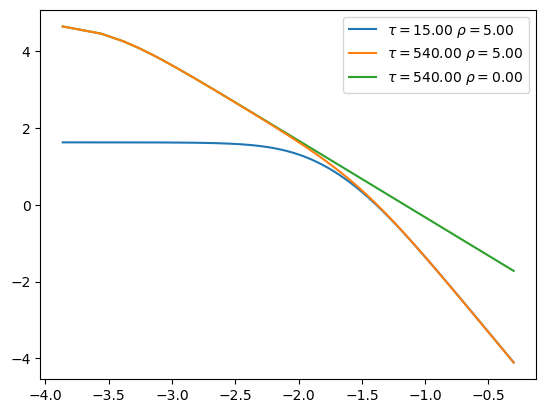

In [5]:
freq = np.fft.rfftfreq(20*365,1)

def get_pow(tau,rho):


    #omega = 2* np.pi* freq[1:]

    #Tau_factor = (1+omega**2 * tau**2)
    #Rho_factor = (1+omega**2 * rho**2)

    #return 1/Tau_factor/Rho_factor
    return simulator.Power_spectrum(freq[1:],tau,rho,grid_step=1,Variance=10)

taus = [15,540,540]
rhos  = [5,5,0]
powers = np.array([get_pow(tau,rho) for tau,rho in zip(taus,rhos)])


Variance_mult = np.array([powers[1,-1]/powers[0,-1],1,powers[1,0]/powers[-1,0]])
zorders = [0,1,0]

for tau,rho,power,var,z in zip(taus,rhos,powers,Variance_mult,zorders):
    plt.plot(np.log10(freq[1:]),np.log10(power*var),label=r'$\tau={:.2f}$'.format(tau)+' '+r'$\rho={:.2f}$'.format(rho),zorder=z)

plt.legend()

In [6]:
time = np.arange(20*365)
time -= time[10*365]

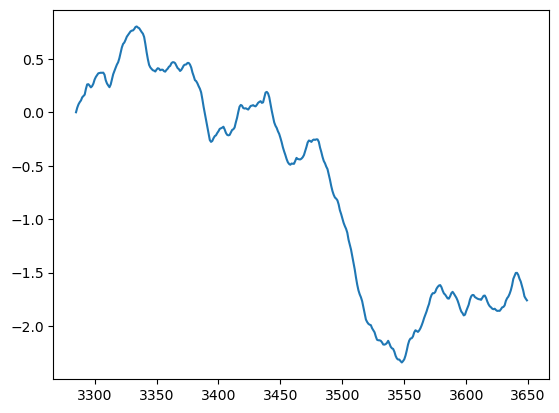

In [8]:
from copy import deepcopy
tau,rho = 350, 5
Cov_matrix = simulator.RDRW_covariance(np.abs(time[:,None]-time[None,:]),tau,rho)
cholesky = scipy.linalg.cholesky(Cov_matrix,lower=True)
noise = np.random.default_rng(11).normal(size=time.shape)
magnitude = cholesky@noise

magnitude = deepcopy(magnitude[time>=9*365])
magnitude/=magnitude.std()
magnitude-=magnitude[0]
plt.plot(time[time>=9*365],magnitude,zorder=0)

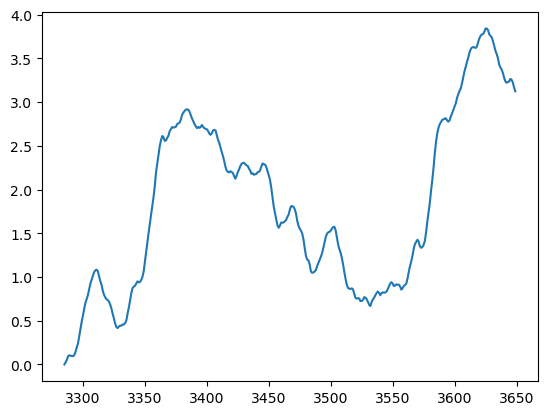

In [141]:
    #4
    magnitude = deepcopy(magnitude[time>=9*365])
    magnitude/=magnitude.std()
    magnitude-=magnitude[0]
    plt.plot(time[time>=9*365],magnitude,zorder=0)

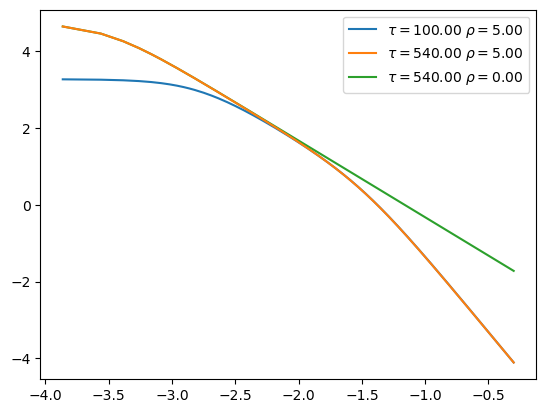

In [9]:
freq = np.fft.rfftfreq(20*365,1)

def get_pow(tau,rho):


    #omega = 2* np.pi* freq[1:]

    #Tau_factor = (1+omega**2 * tau**2)
    #Rho_factor = (1+omega**2 * rho**2)

    #return 1/Tau_factor/Rho_factor
    return simulator.Power_spectrum(freq[1:],tau,rho,grid_step=1,Variance=10)

taus = [100,540,540]
rhos  = [5,5,0]
powers = np.array([get_pow(tau,rho) for tau,rho in zip(taus,rhos)])


Variance_mult = np.array([powers[1,-1]/powers[0,-1],1,powers[1,0]/powers[-1,0]])
zorders = [0,1,0]

for tau,rho,power,var,z in zip(taus,rhos,powers,Variance_mult,zorders):
    plt.plot(np.log10(freq[1:]),np.log10(power*var),label=r'$\tau={:.2f}$'.format(tau)+' '+r'$\rho={:.2f}$'.format(rho),zorder=z)

plt.legend()

In [10]:
magnitudes = []
for tau,rho in tqdm(zip(taus,rhos)):

    Cov_matrix = simulator.RDRW_covariance(np.abs(time[:,None]-time[None,:]),tau,rho)
    cholesky = scipy.linalg.cholesky(Cov_matrix,lower=True)
    noise = np.random.default_rng(4).normal(size=time.shape)
    magnitudes.append(cholesky@noise)

3it [00:15,  5.04s/it]


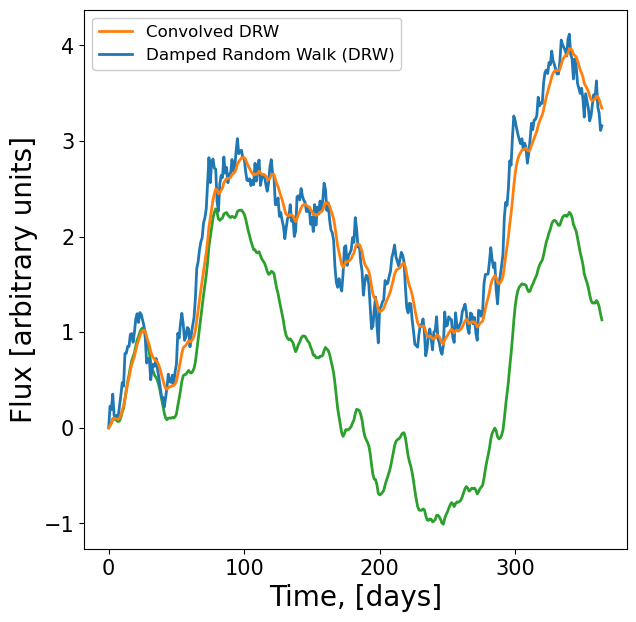

In [11]:
fig,ax = plt.subplots(figsize=(7,7))

colors = ['C2','C1','C0']
labels = [None,'Convolved DRW', 'Damped Random Walk (DRW)']
labels_spec = ['CDRW: ','CDRW: ','DRW: ']

for i,(tau,rho,power,var,z) in enumerate(zip(taus,rhos,powers,Variance_mult,zorders)):
    magnitude = deepcopy(magnitudes[i][time>=9*365])
    magnitude/=magnitude.std()
    magnitude-=magnitude[0]
    t = time[time>=9*365]
    ax.plot(t-t[0],magnitude,zorder=z,linewidth=2,color=colors[i],label=labels[i])

plt.xlabel('Time, [days]',fontsize=20)
plt.ylabel('Flux [arbitrary units]',fontsize=20)
plt.legend(loc='upper left',fontsize=12,framealpha=1)
fig.patch.set_alpha(0.)

ax.tick_params(axis='both', which='major', labelsize=15)

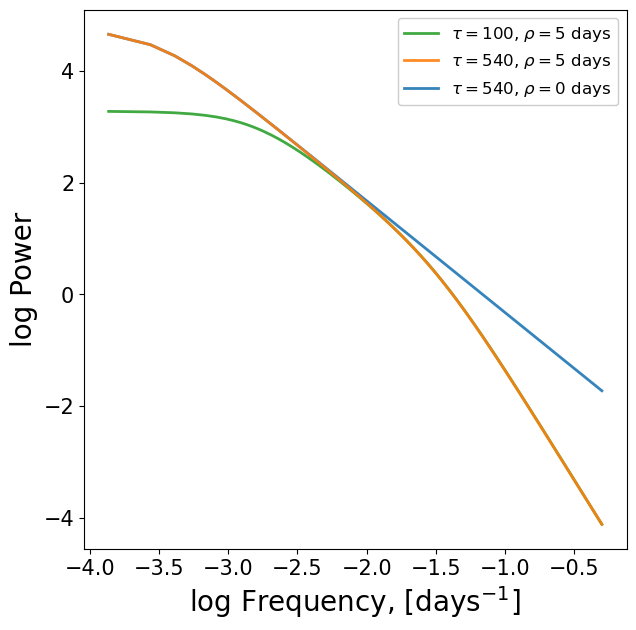

In [15]:
fig,ax = plt.subplots(figsize=(7,7))

colors = ['C2','C1','C0']
labels = [None,'Convolved DRW', 'Damped Random Walk (DRW)']
labels_spec = ['CDRW: ','CDRW: ','DRW: ']

for i,(tau,rho,power,var,z) in enumerate(zip(taus,rhos,powers,Variance_mult,zorders)):

    ax.plot(np.log10(freq[1:]),np.log10(power*var),label=r'$\tau={:.0f}$'.format(tau)+', '+r'$\rho={:.0f}$'.format(rho)+' days',
               zorder=z,linewidth=2,color=colors[i],alpha=0.9)

ax.set_xlabel('log Frequency, [days'+r'$^{-1}$'+']',fontsize=20)
ax.set_ylabel('log Power',fontsize=20)

plt.legend(loc='upper right',fontsize=12,framealpha=1)
fig.patch.set_alpha(0.)

ax.tick_params(axis='both', which='major', labelsize=15)

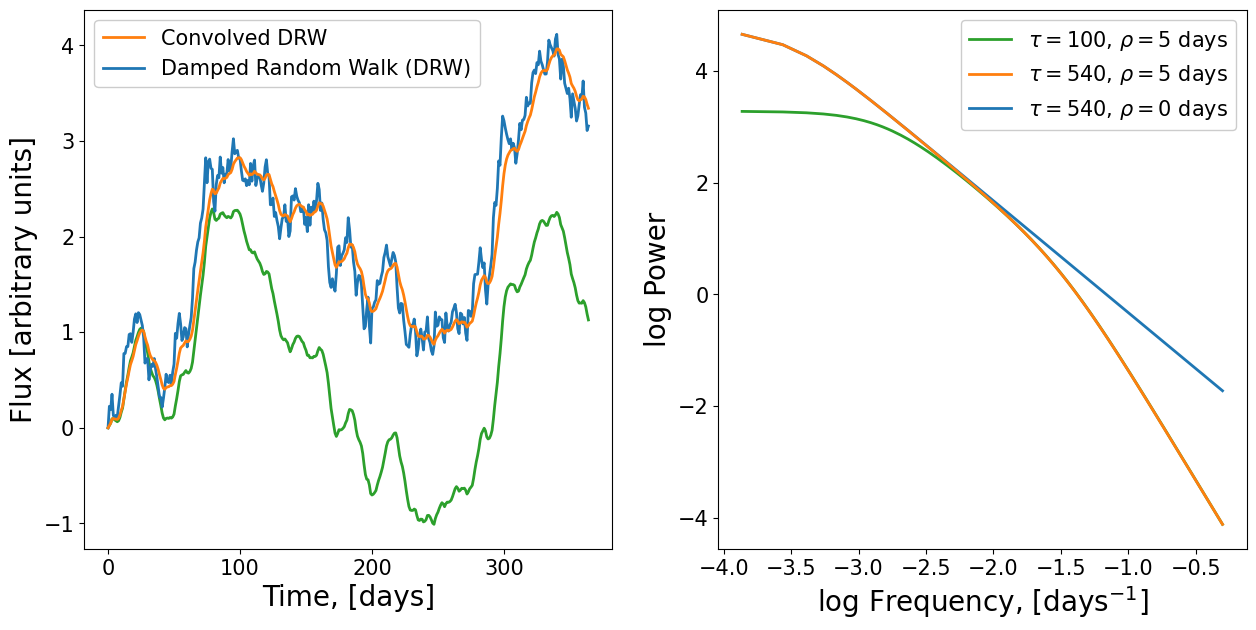

In [172]:
from copy import deepcopy
fig,ax = plt.subplots(1,2,figsize=(15,7))

colors = ['C2','C1','C0']
labels = [None,'Convolved DRW', 'Damped Random Walk (DRW)']
labels_spec = ['CDRW: ','CDRW: ','DRW: ']

for i,(tau,rho,power,var,z) in enumerate(zip(taus,rhos,powers,Variance_mult,zorders)):
    magnitude = deepcopy(magnitudes[i][time>=9*365])
    magnitude/=magnitude.std()
    magnitude-=magnitude[0]
    t = time[time>=9*365]
    ax[0].plot(t-t[0],magnitude,zorder=z,linewidth=2,color=colors[i],label=labels[i])
    ax[1].plot(np.log10(freq[1:]),np.log10(power*var),label=r'$\tau={:.0f}$'.format(tau)+', '+r'$\rho={:.0f}$'.format(rho)+' days',
               zorder=z,linewidth=2,color=colors[i])


ax[0].set_xlabel('Time, [days]',fontsize=20)
ax[0].set_ylabel('Flux [arbitrary units]',fontsize=20)

ax[1].set_xlabel('log Frequency, [days'+r'$^{-1}$'+']',fontsize=20)
ax[1].set_ylabel('log Power',fontsize=20)

ax[0].legend(loc='upper left',fontsize=15,framealpha=1)
ax[1].legend(loc='upper right',fontsize=15,framealpha=1)
fig.patch.set_alpha(0.)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)

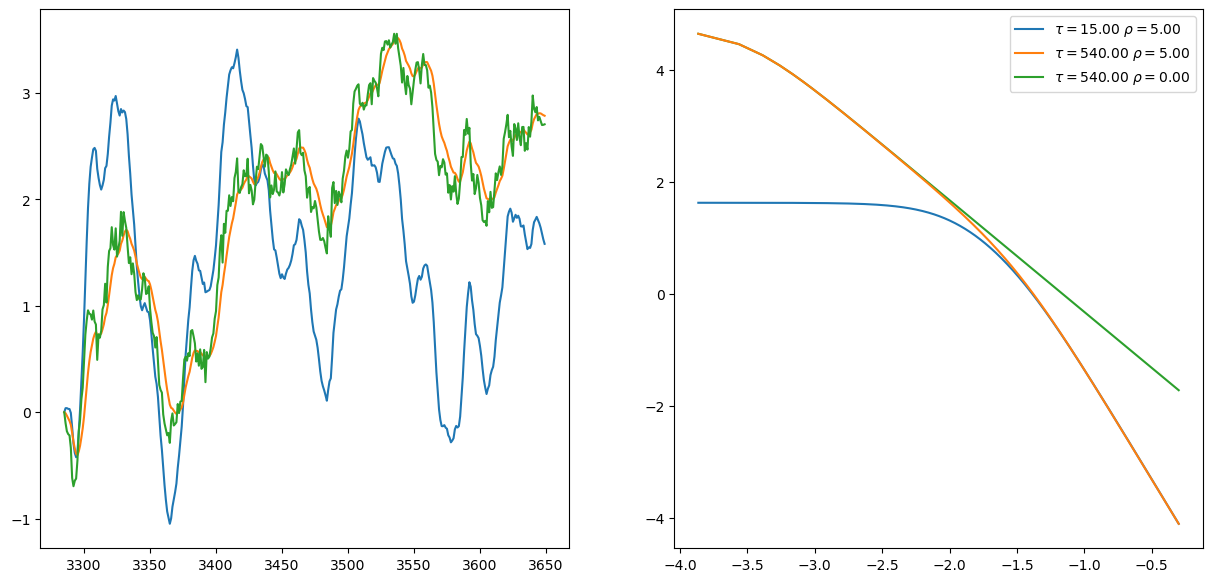

In [127]:
from copy import deepcopy
fig,ax = plt.subplots(1,2,figsize=(15,7))

for i,(tau,rho,power,var,z) in enumerate(zip(taus,rhos,powers,Variance_mult,zorders)):
    magnitude = deepcopy(magnitudes[i][time>=9*365])
    magnitude/=magnitude.std()
    magnitude-=magnitude[0]
    ax[0].plot(time[time>=9*365],magnitude,zorder=0)
    ax[1].plot(np.log10(freq[1:]),np.log10(power*var),label=r'$\tau={:.2f}$'.format(tau)+' '+r'$\rho={:.2f}$'.format(rho),zorder=z)

plt.legend()

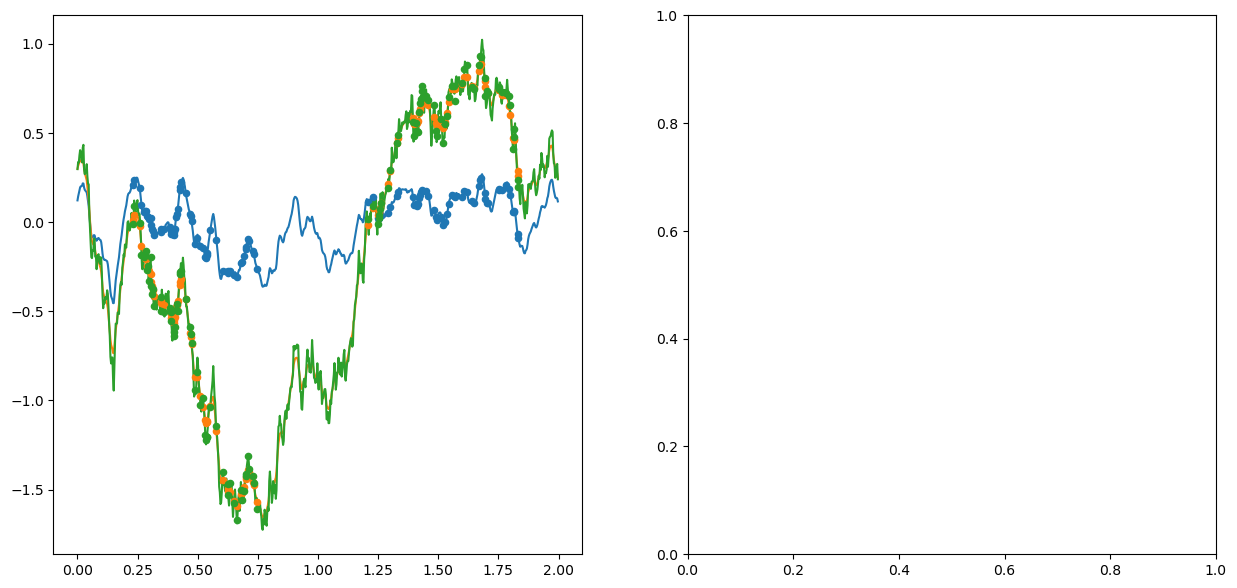

In [94]:
fig,ax = plt.subplots(1,2,figsize=(15,7))

for i,(tau,rho) in enumerate(zip(taus,rhos)):
    magnitude = magnitudes[i]
    test_magnitude = test_magnitudes[i]
    ax[0].scatter(time[mask],magnitude[mask],s=20)
    ax[0].plot(test_time,test_magnitude,zorder=0)

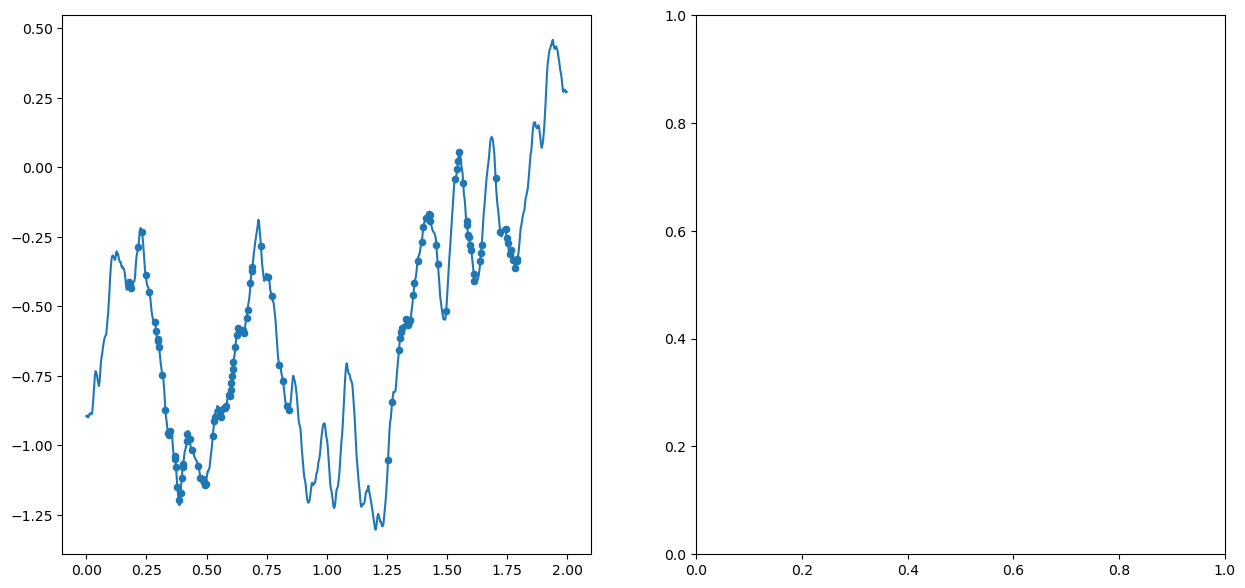